<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/FL/DataKindHousingChallenge3Simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is looking at the DataKind Housing Challenge #3.  Feel free to correct/advise/suggest/improve!  

So far, I'm just looking at the first part of the "getting started" analysis for this challenge.  i.e. am looking at the overlap in census tracts that belong to the:
* the HUD Low Income Housing Tax Credit (LIHTC) program  
* HUD Opportunity Zones Program
* Dept of Treasury CDFI Fund Investment Areas

These are indicated by the follwing columns in the dataset
* qct
* opzone
* investment_areas

Am also looking at the economic_distress of census tracts

# Background

https://github.com/datakind/datakit-housing-fall-2024/discussions/3


Create an understanding of where affordable housing development is likely to be funded or otherwise incentivized. There are several federal government supported programs that offer financial support for affordable housing construction. Starting with three programs, the HUD Low Income Housing Tax Credit (LIHTC) program Qualified Census Tracts, the HUD Opportunity Zones Program Census Tracts, and the Dept of Treasury CDFI Fund Investment Areas. Data from these three programs is contained within the EODatascape. Using this data, create an understanding of housing construction opportunities for financial support at a Census tract level.

...

This “getting started” analysis should help answer the following questions:

* **Do these the geographies for these three programs overlap?**
* Do the geographies align to high population density?
* Does the population breakdown shift by geography?
* Are the areas of incentive in areas of potential environmental hazard?
* Analysis insights and questions: What surprised you from this analysis? What are some limitations of the analysis? What are ways to extend the work?






# Setup


In [2]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles
import seaborn as sns
import zipfile
import requests, io

import numpy as np
#import contextily as ctx
import geopandas as gpd
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [22]:
# Read housing dataset into Panda dataframe df

url = 'https://github.com/datakind/datakit-housing-fall-2024/releases/download/v1.0/housing-data.zip'
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)
df

,geoid,geoid_year,state,county,state_fips_code,county_fips_code,b19083_001e,b19083_001m,economic_distress_pop_agg,economic_distress_simple_agg,...,num_mortgage_originated,number_of_sba504_loans,number_of_sba7a_loans,qct,s2503_c01_024e,s2503_c01_024m,s2503_c03_024e,s2503_c03_024m,s2503_c05_024e,s2503_c05_024m
0,12001000400,2020,12,1,12,1,0.3928,0.0724,YES,YES,...,117.0,5.0,5.0,0,961,110,909,67,1297,405
1,12001000806,2020,12,1,12,1,0.5466,0.0649,YES,YES,...,6.0,1.0,NaN,1,960,38,-666666666,-222222222,971,43
2,12001000901,2020,12,1,12,1,0.3641,0.0878,YES,YES,...,NaN,NaN,NaN,1,778,21,-666666666,-222222222,776,20
3,12001001203,2020,12,1,12,1,0.3662,0.0894,YES,YES,...,79.0,1.0,NaN,0,1255,177,882,99,1587,95
4,12001001514,2020,12,1,12,1,0.5686,0.0634,YES,YES,...,2.0,1.0,NaN,1,1460,226,733,58,1482,183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1600,12033003506,2020,12,33,12,33,0.4322,0.0543,NO,NO,...,159.0,NaN,NaN,1,1364,214,1448,277,1238,315
1601,12033003800,2020,12,33,12,33,0.4402,0.0756,NO,NO,...,121.0,NaN,NaN,0,911,206,781,252,1073,132
1602,12033003900,2020,12,33,12,33,0.4109,0.0580,NO,NO,...,98.0,NaN,2.0,0,808,179,824,99,622,255
1603,12035060206,2020,12,35,12,35,0.4620,0.0618,YES,YES,...,184.0,13.0,4.0,0,587,119,495,127,974,127


Create smaller dataset with just columns relevant to this analysis, with "YES" "NO" converted to "1" "0"

In [23]:
# Create smaller dataframe df2 with just columns relevant to this analysis, with "YES" "NO" converted to "1" "0"
df2 = pd.concat([
                df.geoid,
                df.county,
                df.opzone,
                df.investment_areas.replace({"YES":1,"NO":0}),
                df.qct,
                df.economic_distress_pop_agg.replace({"YES":1,"NO":0}),
                df.economic_distress_simple_agg.replace({"YES":1,"NO":0})
                ], axis=1)

df2

,geoid,county,opzone,investment_areas,qct,economic_distress_pop_agg,economic_distress_simple_agg
0,12001000400,1,1,1,0,1,1
1,12001000806,1,0,1,1,1,1
2,12001000901,1,0,1,1,1,1
3,12001001203,1,0,1,0,1,1
4,12001001514,1,0,1,1,1,1
...,...,...,...,...,...,...,...
1600,12033003506,33,0,1,1,0,0
1601,12033003800,33,0,0,0,0,0
1602,12033003900,33,0,0,0,0,0
1603,12035060206,35,0,1,0,1,1


In [ ]:
# check for columns that are missing data, sorted by percent missing
from numpy import sort
from IPython.display import display

with pd.option_context('display.min_rows', 400):

  display(df2.isna().mean().sort_values(ascending=False)*100)

# "Getting Started" Analysis



## Do these the geographies for these three programs overlap?

### Cross-tabulations

In [ ]:
# do a crosstabulation of number of census tracts in each combination of
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct,df2.investment_areas])

opzone                       0                1           
qct                          0       1        0      1    
investment_areas             0    1  0    1   0   1  0   1
economic_distress_pop_agg                                 
0                          627  367  1   10   1   0  0   0
1                           73  238  1  118  12  83  1  73

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,df2.investment_areas)

investment_areas,0,1
economic_distress_pop_agg,,
0,629,377
1,87,512


In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,df2.opzone)

opzone,0,1
economic_distress_pop_agg,,
0,1005,1
1,430,169


In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.qct])

qct,0,1
economic_distress_pop_agg,,
0,995,11
1,406,193


In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct])

opzone                       0        1    
qct                          0    1   0   1
economic_distress_pop_agg                  
0                          994   11   1   0
1                          311  119  95  74

In [ ]:
pd.crosstab(df2.economic_distress_pop_agg,[df2.opzone,df2.qct]).T.sum()


,0
economic_distress_pop_agg,
0,1006
1,599


### Venn Diagrams

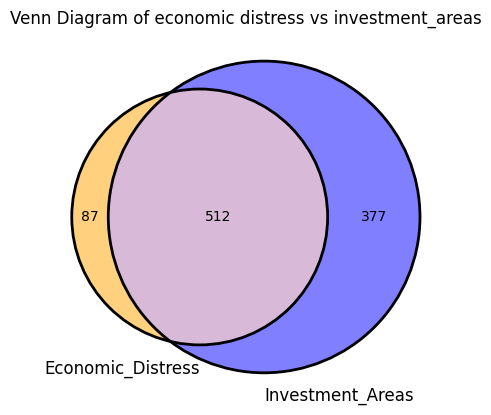

In [ ]:
ctf=pd.crosstab(df2.economic_distress_pop_agg,df2.investment_areas)
# depict venn diagram
subsets = (ctf[0][1], ctf[1][0], ctf[1][1])
venn2(subsets,
      set_labels = ('Economic_Distress',
                    'Investment_Areas'),
      set_colors=("orange",
                  "blue"),alpha=0.5)

# add outline
venn2_circles(subsets)
# assign title of the venn diagram
plt.title("Venn Diagram of economic distress vs investment_areas")
plt.show()


Useful resource for plotting Venn diagrams:
https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/#

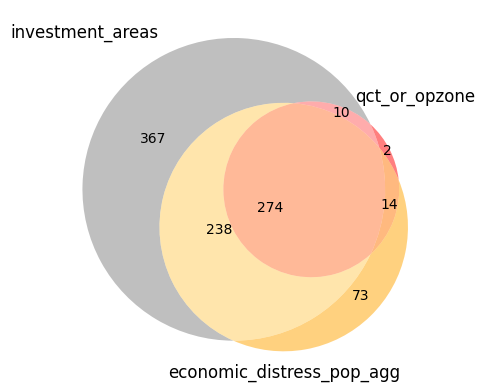

In [ ]:
# create venn diagram without crosstab

setI=set(df2[df2.investment_areas==1].geoid.values)
setEP=set(df2[df2.economic_distress_pop_agg==1].geoid.values)
setES=set(df2[df2.economic_distress_simple_agg==1].geoid.values)

setQ=set(df2[df2.qct==1].geoid.values)
setOP=set(df2[df2.opzone==1].geoid.values)
#venn2((set1, set2), ('investment_areas', 'economic_distress_pop_agg'),set_colors=("blue",
#                  "orange"),alpha=0.5)
#venn3((setI, setEP, setES), ('investment_areas', 'economic_distress_pop_agg','economic_distress_simple_agg'),set_colors=("blue",
#                  "orange","red"),alpha=0.5)
#venn3((setI,setQ,setOP),('investment_areas','qct','opzone'),set_colors=("blue","green","red"),alpha=0.5)
setM=set(df2.query("qct==1 or opzone==1").geoid.values)
venn3((setI,setM,setEP),('investment_areas', 'qct_or_opzone','economic_distress_pop_agg'),set_colors=("grey","red","orange"),alpha=0.5)
plt.show()
#set2

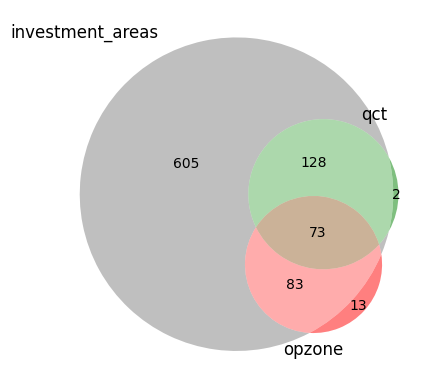

In [ ]:
venn3((setI,setQ,setOP),('investment_areas','qct','opzone'),set_colors=("grey","green","red"),alpha=0.5)
#venn3_circles(subsets=(setI,setQ,setOP),
#              linestyle="dashed", linewidth=2)
plt.show()

### Geospatial visualizations


This section is under construction!  I got as far as reading in a shape file to make visualizations possible, but no further yet.  

In [16]:
# perhaps I should be using 2020 or 2022 data instead? Not sure

url="https://github.com/kodiakpony/datakit-housing-fall-2024/raw/refs/heads/main/challenge-3/cb_2023_12_tract_500k.zip"
gdf = gpd.read_file(url)

<Axes: >

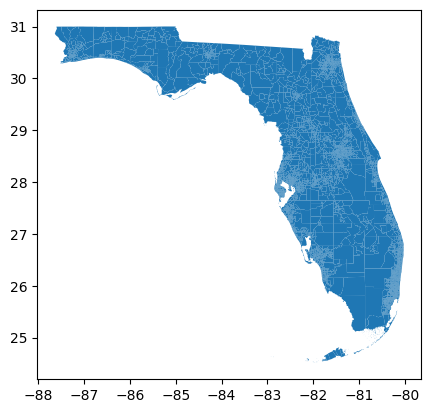

In [17]:
gdf.plot()

In [25]:
gdf.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOIDFQ', 'GEOID', 'NAME',
       'NAMELSAD', 'STUSPS', 'NAMELSADCO', 'STATE_NAME', 'LSAD', 'ALAND',
       'AWATER', 'geometry'],
      dtype='object')

#Appendix


## Newbie notes


Some useful references for python zip file csv reading:

https://docs.python.org/3/library/zipfile.html

https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

https://www.geeksforgeeks.org/with-statement-in-python/



Useful resource for plotting Venn diagrams: https://www.geeksforgeeks.org/how-to-create-and-customize-venn-diagrams-in-python/#

Am currently trying to find a map of census tracts to load to be able to visualize data geographically.

Have spent way too long trying to figure this out! I think the right place to get data is from census.gov. I found a useful description of geoids here:

https://www.census.gov/programs-surveys/geography/guidance/geo-identifiers.html

and a way to download TIGER files here:

https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html

and some promising looking tutorials and Q&A here:

https://medium.com/@jl_ruiz/plot-maps-from-the-us-census-bureau-using-geopandas-and-contextily-in-python-df787647ef77

https://stackoverflow.com/questions/76369026/how-to-access-us-census-tiger-shapefiles-in-geopandas

https://www.natekratzer.com/posts/census_map/

So hopefully between those and the example someone else already did for DataKit, I can figure this out! Still plugging away, though.

## Broken things / scratch space



In [20]:
import geopandas as gpd
# input vars
state_id = 78
year = 2020
file_type='bg'
#file_type='tr'

# load TIGER from URI
uri = f"https://www2.census.gov/geo/tiger/TIGER{year}/{file_type.upper()}/tl_{year}_{state_id}_{file_type.lower()}.zip"
#uri = "cb_2023_12_tract_500k.zip"
example_blockgroups = gpd.read_file(uri)

In [8]:
example_blockgroups

,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,78,020,950200,4,780209502004,Block Group 4,G5030,S,2680124,1602919,+18.3206200,-064.7694590,"POLYGON ((-64.78008 18.31127, -64.78004 18.311..."
1,78,010,970400,1,780109704001,Block Group 1,G5030,S,3434850,0,+17.7342265,-064.7279517,"POLYGON ((-64.73969 17.73898, -64.73912 17.739..."
2,78,030,960300,2,780309603002,Block Group 2,G5030,S,655727,0,+18.3464603,-064.8958709,"POLYGON ((-64.90169 18.34612, -64.9019 18.3470..."
3,78,010,970400,3,780109704003,Block Group 3,G5030,S,1907785,0,+17.7213104,-064.7238747,"POLYGON ((-64.73417 17.72253, -64.73395 17.722..."
4,78,030,960100,2,780309601002,Block Group 2,G5030,S,531274,0,+18.3414467,-064.8742794,"POLYGON ((-64.87848 18.34419, -64.87844 18.344..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,78,010,990000,0,780109900000,Block Group 0,G5030,S,0,628020443,+17.7618969,-064.5681786,"POLYGON ((-64.95671 17.67898, -64.95638 17.683..."
88,78,010,970100,2,780109701002,Block Group 2,G5030,S,21161877,2708636,+17.7490804,-064.6198863,"MULTIPOLYGON (((-64.6284 17.78894, -64.62836 1..."
89,78,030,960700,3,780309607003,Block Group 3,G5030,S,3587109,6788745,+18.3146204,-064.8348238,"MULTIPOLYGON (((-64.84551 18.30394, -64.84548 ..."
90,78,030,960200,2,780309602002,Block Group 2,G5030,S,564367,0,+18.3384074,-064.8772236,"POLYGON ((-64.88231 18.34241, -64.8821 18.3425..."


In [19]:
import folium, matplotlib
#import mapclassify
example_blockgroups.explore()


ImportError: The 'folium', 'matplotlib' and 'mapclassify' packages are required for 'explore()'. You can install them using 'conda install -c conda-forge folium matplotlib mapclassify' or 'pip install folium matplotlib mapclassify'.